In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openslide, pymysql, tifffile, json, cv2

In [2]:
conn = pymysql.connect(host="localhost", user="wsiviewer", password="1q2w3e4r", db="showinfos")
cur = conn.cursor()

In [3]:
cur.execute("SELECT * FROM wsiluadinfo WHERE wli_id = 'TCGA-38-A44F-01Z-00-DX1';")
results = cur.fetchall()

wsiluadinfo = {}
for data in results:
    corrdihuman = data[2]
    corrdilearn = data[3]
    if bool(data[2]):
        corrdihuman = json.loads(corrdihuman)
    if bool(data[3]):
        corrdilearn = json.loads(corrdilearn)
    tmpDic = {"filepath" : data[1], "corrdihuman" : corrdihuman, "corrdilearn" : corrdilearn}
    wsiluadinfo[data[0]] = tmpDic

In [4]:
pathWSI = wsiluadinfo["TCGA-38-A44F-01Z-00-DX1"]["filepath"]
handleWSI = openslide.OpenSlide(pathWSI)
coordinates = wsiluadinfo["TCGA-38-A44F-01Z-00-DX1"]["corrdihuman"]["coordinates"]

In [5]:
handleWSI.level_dimensions

((185639, 44659), (46409, 11164), (11602, 2791), (2900, 697))

In [6]:
img = np.array(handleWSI.read_region((0, 0), 2, handleWSI.level_dimensions[2]).convert("RGB"))

In [7]:
imgH, imgS, imgV = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL))
imgL = cv2.Laplacian(imgV, cv2.CV_8U, ksize=3)

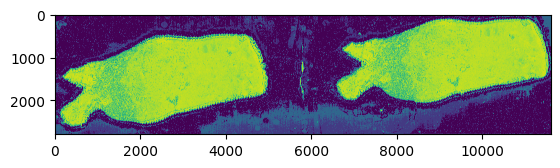

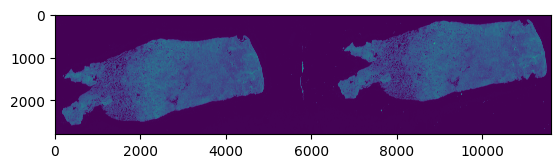

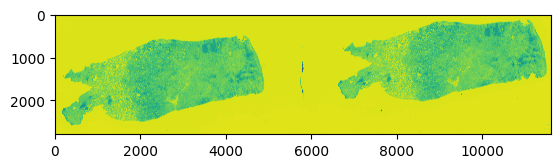

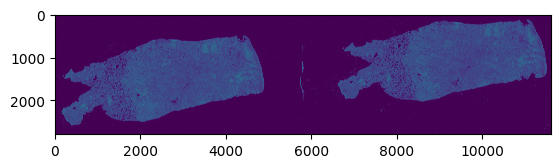

In [8]:
plt.imshow(imgH)
plt.show()
plt.imshow(imgS)
plt.show()
plt.imshow(imgV)
plt.show()
plt.imshow(imgL)
plt.show()

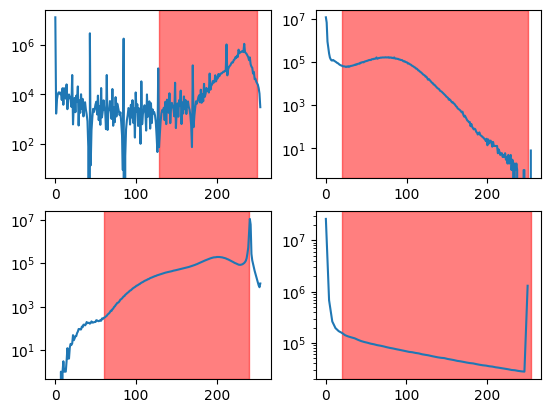

In [9]:
rangeSelect = {'h' : (128, 250),'s' : (20, 250),'v' : (60, 240),'l' : (20, 255)}

histH, xH = np.histogram(np.hstack(imgH), bins=256, range=(0, 255))
histS, xS = np.histogram(np.hstack(imgS), bins=256, range=(0, 255))
histV, xV = np.histogram(np.hstack(imgV), bins=256, range=(0, 255))
histL, xL = np.histogram(np.hstack(imgL), bins=64, range=(0, 255))

plt.subplot(2,2,1)
plt.axvspan(rangeSelect['h'][0], rangeSelect['h'][1], alpha=0.5, color='red')
plt.plot(xH[:-1], histH)
plt.yscale("log")
plt.subplot(2,2,2)
plt.axvspan(rangeSelect['s'][0], rangeSelect['s'][1], alpha=0.5, color='red')
plt.plot(xS[:-1], histS)
plt.yscale("log")
plt.subplot(2,2,3)
plt.axvspan(rangeSelect['v'][0], rangeSelect['v'][1], alpha=0.5, color='red')
plt.plot(xV[:-1], histV)
plt.yscale("log")
plt.subplot(2,2,4)
plt.axvspan(rangeSelect['l'][0], rangeSelect['l'][1], alpha=0.5, color='red')
plt.plot(xL[:-1], histL)
plt.yscale("log")
plt.show()

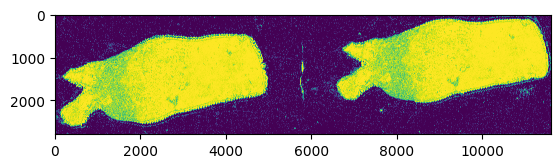

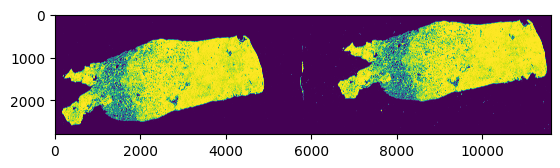

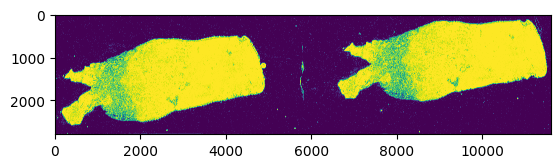

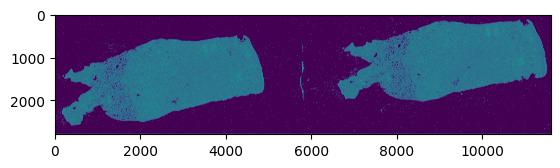

In [10]:
imgH = cv2.inRange(imgH, rangeSelect['h'][0], rangeSelect['h'][1])
imgS = cv2.inRange(imgS, rangeSelect['s'][0], rangeSelect['s'][1])
imgV = cv2.inRange(imgV, rangeSelect['v'][0], rangeSelect['v'][1])
imgL = cv2.inRange(imgL, rangeSelect['l'][0], rangeSelect['l'][1])
plt.imshow(imgH)
plt.show()
plt.imshow(imgS)
plt.show()
plt.imshow(imgV)
plt.show()
plt.imshow(imgL)
plt.show()

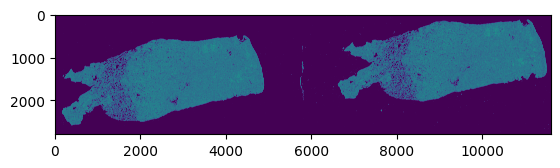

In [11]:
imgT = (imgH * imgS * imgV * imgL).astype(float)
plt.imshow(imgT)
plt.show()

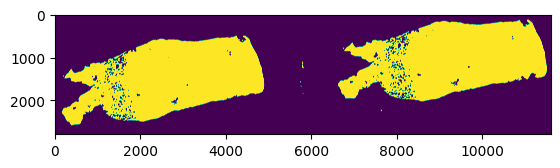

In [12]:
imgM = cv2.inRange(cv2.GaussianBlur(imgT, (31, 31), 21), 0.2, 1).astype(bool)
plt.imshow(imgM)
plt.show()

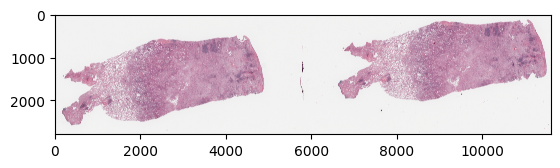

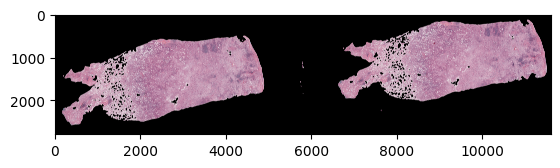

In [13]:
plt.imshow(img)
plt.show()
img[imgM == False] = 0
plt.imshow(img)
plt.show()

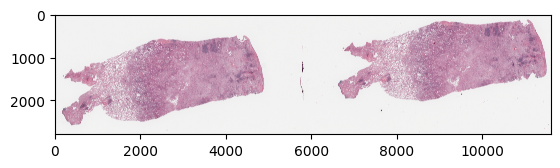

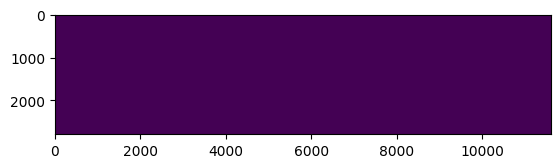

In [14]:
img = np.array(handleWSI.read_region((0, 0), 2, handleWSI.level_dimensions[2]).convert("RGB"))
mask = np.zeros((handleWSI.level_dimensions[2][1],handleWSI.level_dimensions[2][0]), dtype=np.uint8)
plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()

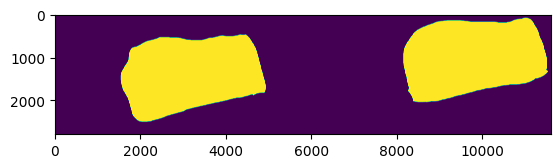

In [15]:
for coordinatesParts in coordinates:
    coordinatesMini = (np.array(coordinatesParts[0]) / handleWSI.level_downsamples[2]).astype(int)
    mask = cv2.fillPoly(mask, pts=[coordinatesMini], color=1)
mask = mask.astype(bool)
plt.imshow(mask)
plt.show()

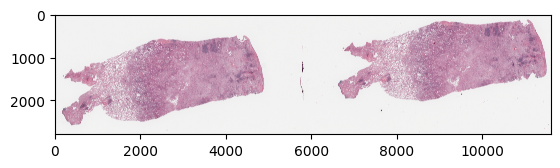

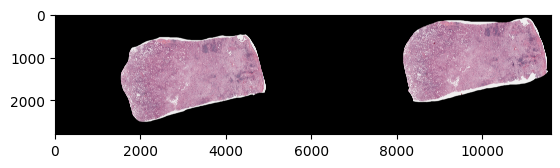

In [16]:
plt.imshow(img)
plt.show()
img[mask == False] = 0
plt.imshow(img)
plt.show()

In [17]:
mask = (mask*255).astype(np.uint8)

In [26]:
mask.shape

(2791, 11602)

In [22]:
tifffile.imwrite("test.tif", np.stack([mask, mask, mask], 2), compression="lzw", bigtiff=True, tile=(256, 256))

In [24]:
handleMask = tifffile.imread("./test.tif")

In [32]:
np.max(handleMask)

255

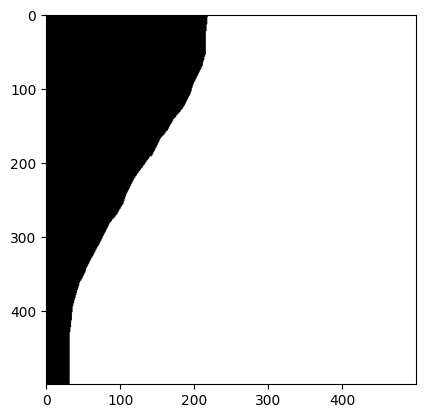

In [33]:
plt.imshow(handleMask[1000:1500, 1500:2000])
plt.show()